In [676]:
import pandas as pd
# pd.options.display.max_rows = None
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [677]:
df_train = pd.read_csv('../data/iith_foml_2023_train.csv')
df_corr = df_train.corr()
drop_cols = ['Feature 3 (Discrete)', 'Feature 10', 'Feature 14', 'Feature 16', 'Feature 17', 'Feature 23 (Discrete)']
# display(df_corr.where(df_corr > 0.75))
df_train.drop(columns=drop_cols, inplace=True)
# for column in df_train.columns:
#     if df_train[column].isna().any():
#         mean_value = df_train[column].mode()[0]
#         df_train[column].fillna(mean_value, inplace=True)
df_train.fillna(1e9, inplace=True)


In [678]:
class_counts = df_train["Target Variable (Discrete)"].value_counts()
print(class_counts)


Target Variable (Discrete)
1     488
0     249
2     109
6      70
5      41
8       7
14      5
7       5
15      4
4       3
13      3
3       3
9       2
12      1
17      1
11      1
10      1
16      1
Name: count, dtype: int64


In [679]:
import numpy as np
import pandas as pd

# Assuming class_counts is defined somewhere in your code
minority_classes = class_counts[class_counts < 500].index

df_oversampled = pd.DataFrame()

for cls in minority_classes:
    minority_instances = df_train[df_train["Target Variable (Discrete)"] == cls]
    oversampled_instances = minority_instances.sample(n=500, replace=True, random_state=42)

    # Add Gaussian noise
    noise = np.random.normal(loc=0, scale=0.1, size=oversampled_instances.shape)
    oversampled_instances_with_noise = oversampled_instances + noise


    df_oversampled = pd.concat([df_oversampled, oversampled_instances_with_noise])
    
df_oversampled["Target Variable (Discrete)"] = df_oversampled["Target Variable (Discrete)"].round()
print(df_oversampled["Target Variable (Discrete)"].value_counts())


Target Variable (Discrete)
 1.0     500
-0.0     500
 10.0    500
 11.0    500
 17.0    500
 12.0    500
 9.0     500
 3.0     500
 13.0    500
 4.0     500
 15.0    500
 7.0     500
 14.0    500
 8.0     500
 5.0     500
 6.0     500
 2.0     500
 16.0    500
Name: count, dtype: int64


In [680]:
X = df_oversampled.iloc[:, :-1]
y = df_oversampled.iloc[:, -1]
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [681]:
X_train, val_x, y_train, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [682]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=42)
# X_train, y_train = ros.fit_resample(X, y)


# X_train, val_x, y_train, val_y = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [683]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import XGBClassifier

def report_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro', zero_division=0.0)

model = KNeighborsClassifier(n_neighbors=7, n_jobs=-1, weights='distance')
# model = XGBClassifier()

cv_f1_score = cross_val_score(model, X_train, y_train, scoring=make_scorer(report_f1))
print(cv_f1_score)

model.fit(X_train, y_train)

[0.9873696  0.98739263 0.98188288 0.99095979 0.98591055]


KNeighborsClassifier(n_jobs=-1, n_neighbors=7, weights='distance')

In [684]:
y_val_pred = model.predict(val_x)
macro_f1 = f1_score(val_y, y_val_pred, average='macro')

print(f'Macro F1 Score: {macro_f1}')

Macro F1 Score: 0.99315041425579


In [685]:
cv_f1_score = cross_val_score(model, X_train, y_train, scoring=make_scorer(report_f1))
print(cv_f1_score)

[0.9873696  0.98739263 0.98188288 0.99095979 0.98591055]


In [686]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

dt_classification_rep = classification_report(val_y, y_val_pred, zero_division=0.0)
print("\n Classification Report:\n", dt_classification_rep)


 Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.94      0.97        88
         1.0       0.99      0.96      0.98       107
         2.0       0.99      0.98      0.99       105
         3.0       0.98      1.00      0.99       110
         4.0       0.99      1.00      0.99        95
         5.0       0.99      0.99      0.99        88
         6.0       0.99      1.00      1.00       106
         7.0       0.99      1.00      0.99        91
         8.0       1.00      1.00      1.00        91
         9.0       1.00      1.00      1.00       108
        10.0       1.00      1.00      1.00        93
        11.0       0.98      1.00      0.99       103
        12.0       1.00      1.00      1.00       101
        13.0       1.00      1.00      1.00        97
        14.0       0.99      1.00      1.00       100
        15.0       1.00      1.00      1.00       108
        16.0       1.00      1.00      1.00       108
 

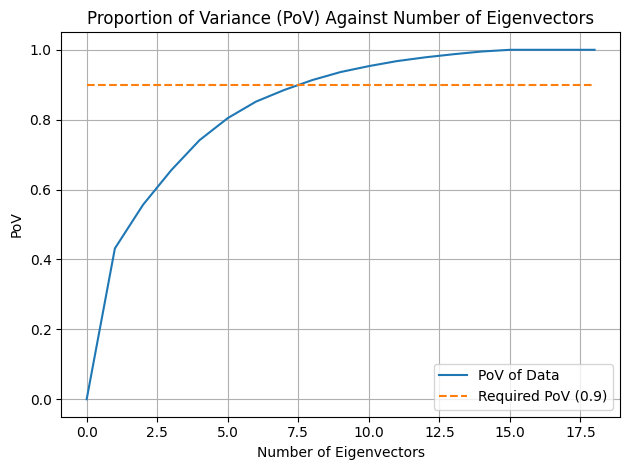

In [687]:
from sklearn.decomposition import PCA
full_pca = PCA()
X_pca = full_pca.fit_transform(X)
# PoV array (zero padded at the start)
cumulative_variance = np.zeros(len(full_pca.explained_variance_ratio_) + 1)
cumulative_variance[1:] = np.cumsum(full_pca.explained_variance_ratio_)

# Plot the cumulative variance as well as cutoff 0.9 PoV
plt.plot(cumulative_variance)
plt.plot(np.arange(cumulative_variance.shape[0]), 0.9*np.ones_like(cumulative_variance), '--')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('PoV')
plt.title('Proportion of Variance (PoV) Against Number of Eigenvectors')
plt.legend(['PoV of Data', 'Required PoV (0.9)'])
plt.grid()
plt.tight_layout()
plt.show()

In [688]:
pca_comp = np.searchsorted(cumulative_variance, 0.9)
pca_comp

8